In [1]:
import os
import pandas as pd
from PIL import Image

In [2]:
training_data_path = "../tmp/cropped_training"
testing_data_path = "../tmp/cropped_testing"

In [3]:
# function to get the label from the file name
def get_label_from_filename(filename):
    label = filename.split('-')[0]
    return label

In [4]:
# load the files into a dataframe
def load_files_to_dataframe(path):
    data = []
    for filename in os.listdir(path):
        label = get_label_from_filename(filename)
        image_path = os.path.join(path, filename)
        image = Image.open(image_path)
        data.append({'image': image, 'label': label,})
    return pd.DataFrame(data)

In [5]:
train_df = load_files_to_dataframe(training_data_path)
test_df = load_files_to_dataframe(testing_data_path)

In [6]:
# split into train and test sets for X and Y 
X_train = train_df['image']
X_test = test_df['image']
y_train = train_df['label']
y_test = test_df['label']

Efficientnet

In [7]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

In [8]:
def preprocess_images(images, target_size=(224, 224)):
    processed_images = []
    for img in images:
        img = img.resize(target_size)
        img_array = img_to_array(img)
        img_array = tf.keras.applications.efficientnet.preprocess_input(img_array)
        processed_images.append(img_array)
    return np.array(processed_images)

In [9]:
X_train_processed = preprocess_images(X_train)
X_test_processed = preprocess_images(X_test)

In [10]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Number of classes
num_classes = len(label_encoder.classes_)
print(f"Number of classes: {num_classes}")
print(f"Classes: {label_encoder.classes_}")

Number of classes: 26
Classes: ['4011' '4015' '4088' '4196' '7020097009819' '7020097026113'
 '7023026089401' '7035620058776' '7037203626563' '7037206100022'
 '7038010009457' '7038010013966' '7038010021145' '7038010054488'
 '7038010068980' '7039610000318' '7040513000022' '7040513001753'
 '7040913336684' '7044610874661' '7048840205868' '7071688004713'
 '7622210410337' '90433917' '90433924' '94011']


In [11]:
import joblib

# Save the label encoder for inference
joblib.dump(label_encoder, '../out/label_encoder.pkl')
print("Label encoder saved to 'label_encoder.pkl'")

Label encoder saved to 'label_encoder.pkl'


In [12]:
def create_model(num_classes):
    # Load EfficientNetB0 with pre-trained weights (excluding top layers)
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    
    # Add custom classification layers
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    
    # Create the model
    model = Model(inputs=base_model.input, outputs=predictions)
    
    # Freeze base model layers
    for layer in base_model.layers:
        layer.trainable = False
    
    return model

In [13]:
model = create_model(num_classes)
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [14]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint = ModelCheckpoint(
    '../out/efficientnet_best_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

In [15]:
history = model.fit(
    X_train_processed,
    y_train_encoded,
    batch_size=32,
    epochs=10,
    validation_split=0.2,
    callbacks=[checkpoint, early_stopping]
)

Epoch 1/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step - accuracy: 0.6942 - loss: 1.2775
Epoch 1: val_accuracy improved from -inf to 0.97241, saving model to ../out/efficientnet_best_model.h5


150/150 ━━━━━━━━━━━━━━━━━━━━ 57s 358ms/step - accuracy: 0.6954 - loss: 1.2729 - val_accuracy: 0.9724 - val_loss: 0.1150
Epoch 2/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step - accuracy: 0.9884 - loss: 0.0729
Epoch 2: val_accuracy improved from 0.97241 to 0.98077, saving model to ../out/efficientnet_best_model.h5


150/150 ━━━━━━━━━━━━━━━━━━━━ 52s 348ms/step - accuracy: 0.9884 - loss: 0.0728 - val_accuracy: 0.9808 - val_loss: 0.0704
Epoch 3/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step - accuracy: 0.9967 - loss: 0.0297
Epoch 3: val_accuracy improved from 0.98077 to 0.99415, saving model to ../out/efficientnet_best_model.h5


150/150 ━━━━━━━━━━━━━━━━━━━━ 52s 348ms/step - accuracy: 0.9967 - loss: 0.0297 - val_accuracy: 0.9941 - val_loss: 0.0361
Epoch 4/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step - accuracy: 0.9962 - loss: 0.0198
Epoch 4: val_accuracy did not improve from 0.99415
150/150 ━━━━━━━━━━━━━━━━━━━━ 51s 341ms/step - accuracy: 0.9962 - loss: 0.0198 - val_accuracy: 0.9933 - val_loss: 0.0259
Epoch 5/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step - accuracy: 0.9989 - loss: 0.0119
Epoch 5: val_accuracy improved from 0.99415 to 0.99666, saving model to ../out/efficientnet_best_model.h5


150/150 ━━━━━━━━━━━━━━━━━━━━ 51s 342ms/step - accuracy: 0.9989 - loss: 0.0119 - val_accuracy: 0.9967 - val_loss: 0.0200
Epoch 6/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step - accuracy: 0.9997 - loss: 0.0069
Epoch 6: val_accuracy did not improve from 0.99666
150/150 ━━━━━━━━━━━━━━━━━━━━ 51s 340ms/step - accuracy: 0.9997 - loss: 0.0069 - val_accuracy: 0.9941 - val_loss: 0.0207
Epoch 7/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step - accuracy: 0.9999 - loss: 0.0050
Epoch 7: val_accuracy did not improve from 0.99666
150/150 ━━━━━━━━━━━━━━━━━━━━ 50s 337ms/step - accuracy: 0.9999 - loss: 0.0050 - val_accuracy: 0.9950 - val_loss: 0.0151
Epoch 8/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step - accuracy: 0.9995 - loss: 0.0055
Epoch 8: val_accuracy did not improve from 0.99666
150/150 ━━━━━━━━━━━━━━━━━━━━ 50s 336ms/step - accuracy: 0.9995 - loss: 0.0055 - val_accuracy: 0.9967 - val_loss: 0.0169
Epoch 9/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step - accuracy: 1.0000 - loss: 0.0029
Epoch 9: val_ac

In [16]:
test_loss, test_accuracy = model.evaluate(X_test_processed, y_test_encoded)
print(f"Test accuracy: {test_accuracy:.4f}")
print(f"Test loss: {test_loss:.4f}")

48/48 ━━━━━━━━━━━━━━━━━━━━ 13s 259ms/step - accuracy: 0.9799 - loss: 0.0527
Test accuracy: 0.9794
Test loss: 0.0552


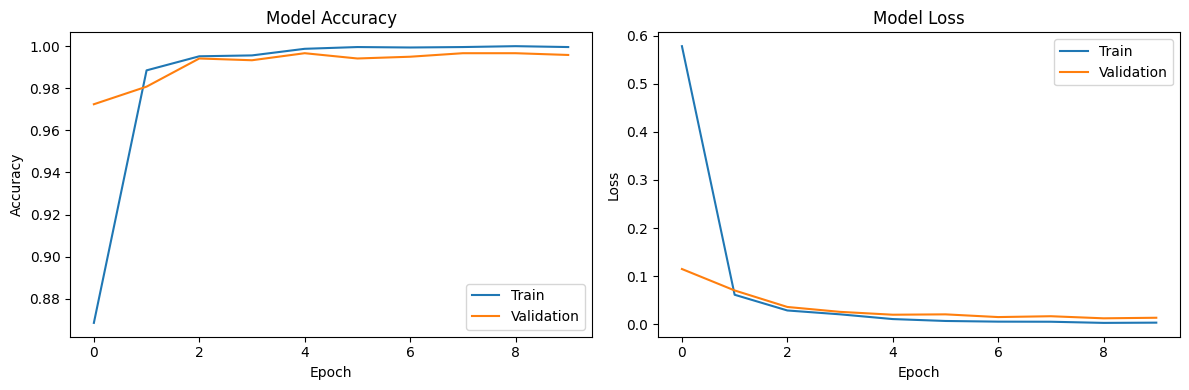

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.tight_layout()
plt.show()

In [18]:
y_pred = model.predict(X_test_processed)
y_pred_classes = np.argmax(y_pred, axis=1)

48/48 ━━━━━━━━━━━━━━━━━━━━ 14s 271ms/step


In [19]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

print(classification_report(y_test_encoded, y_pred_classes, target_names=label_encoder.classes_))

               precision    recall  f1-score   support

         4011       1.00      0.90      0.95        58
         4015       1.00      1.00      1.00        58
         4088       1.00      1.00      1.00        58
         4196       1.00      1.00      1.00        58
7020097009819       1.00      1.00      1.00        58
7020097026113       1.00      1.00      1.00        58
7023026089401       0.95      1.00      0.97        58
7035620058776       0.98      1.00      0.99        58
7037203626563       1.00      1.00      1.00        58
7037206100022       1.00      1.00      1.00        58
7038010009457       1.00      1.00      1.00        58
7038010013966       0.91      1.00      0.95        58
7038010021145       0.96      0.90      0.93        58
7038010054488       0.98      0.98      0.98        58
7038010068980       1.00      1.00      1.00        58
7039610000318       1.00      0.98      0.99        58
7040513000022       1.00      0.93      0.96        58
704051300

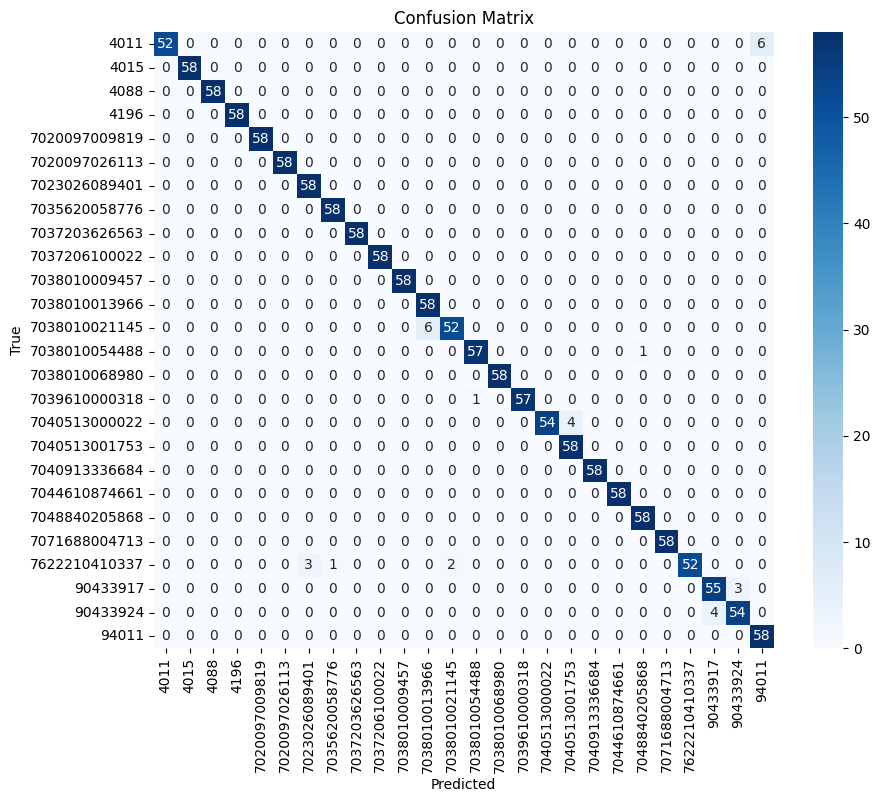

In [20]:
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test_encoded, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()